In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Попробуйте видоизменить параметры разобранной на уроке нейронной сети таким образом, чтобы улучшить ее точность.

In [2]:
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    
    return binarized

def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))
    
    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if l[j] == 1:
                arr[i] = j+1
                
    return arr

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

def normalize(X, axis=1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def view_pred(layer, y, accuracy, N=50):
    plt.figure(figsize=(16, 5))
    plt.plot(layer[:N,1], label='Y new')
    plt.plot(y[:N,1], label='Y train')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend()
    plt.show()
    
    print(f"Аккуратность нейронной сети {round(accuracy,2)}%")

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


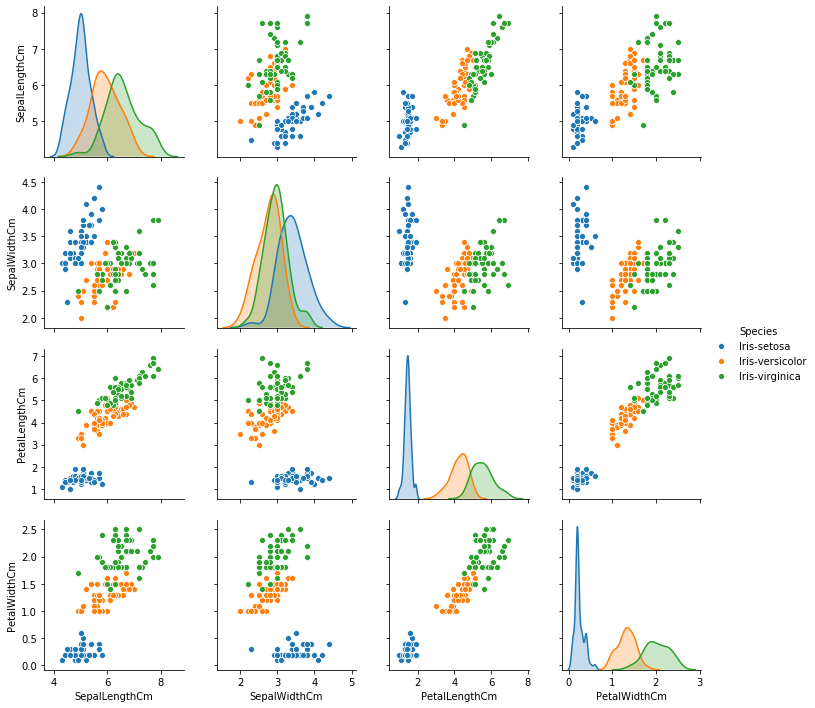

In [3]:
PATH_TO_IRIS = '..\\datas\\Iris.csv'
iris_data = pd.read_csv(PATH_TO_IRIS)
print(iris_data.head())

g = sns.pairplot(iris_data.drop('Id', axis=1), hue="Species")

iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0,1,2], inplace=True)

columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.as_matrix())

columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.as_matrix()
y = y.flatten()
y = to_one_hot(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

## Train

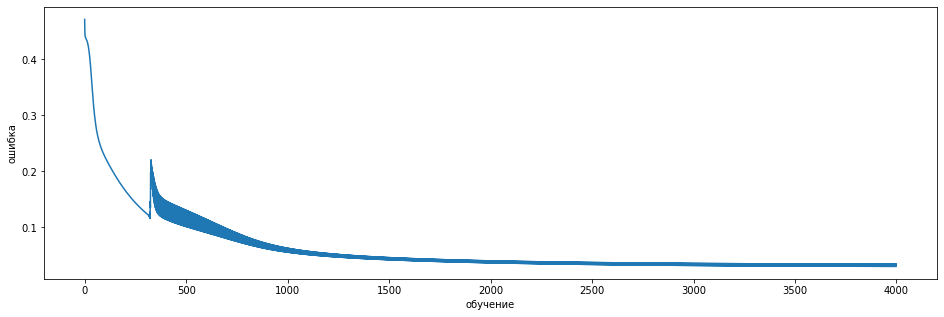

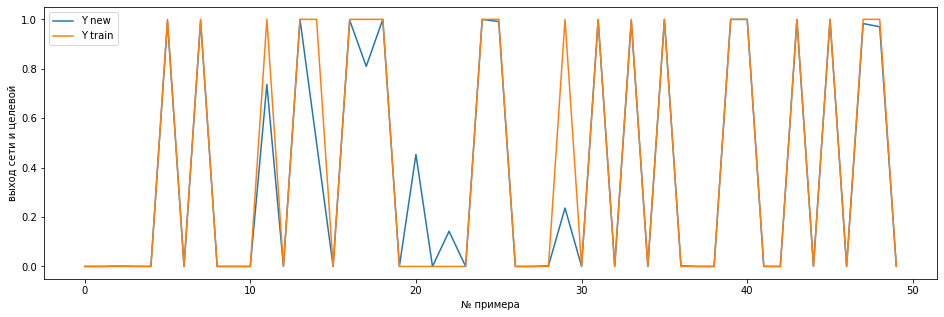

Аккуратность нейронной сети 96.56%


In [4]:
# гиперпараметры
hidden_neurons = 4
learning_rate = 0.1
iterations = 4000

# иницализация весов
np.random.seed(42)
w0 = 2*np.random.random((4, hidden_neurons)) - 1 # для входного слоя   - 4 входа, 3 выхода
w1 = 2*np.random.random((hidden_neurons, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

errors = []

# процесс обучения
for i in range(iterations):
    
    # feed forward
    layer0 = X_train
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = sigmoid(np.dot(layer1, w1))
    
    # back propagation
    layer2_error = y_train - layer2
    layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
    layer1_error = layer2_delta.dot(w1.T)
    layer1_delta = layer1_error * sigmoid_deriv(layer1)
    
    w1 += layer1.T.dot(layer2_delta) * learning_rate
    w0 += layer0.T.dot(layer1_delta) * learning_rate
    
    # model metric
    error = np.mean(np.abs(layer2_error))
    errors.append(error)
    accuracy = (1 - error) * 100
    
plt.figure(figsize=(16, 5))
plt.plot(errors)
plt.xlabel('обучение')
plt.ylabel('ошибка')
plt.show()

view_pred(layer=layer2, y=y_train, accuracy=accuracy)

## Test

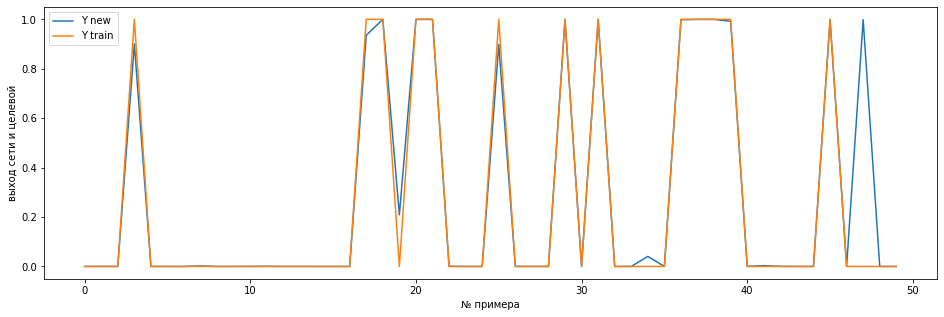

Аккуратность нейронной сети 97.52%


In [5]:
# feed forward
layer0_t = X_test
layer1_t = sigmoid(np.dot(layer0_t, w0))
layer2_t = sigmoid(np.dot(layer1_t, w1))

layer2_error_t = y_test - layer2_t

# model metric
error_t = np.mean(np.abs(layer2_error_t))
accuracy_t = (1 - error_t) * 100

error_t = np.mean(np.abs(layer2_error_t))

view_pred(layer=layer2_t, y=y_test, accuracy=accuracy_t)

# Проведите анализ:
# Что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

##### Ответ:
Замечено, что как и с моделями машинного обучения здесь играет роль правильная настройка гиперпараметров - слишком низкие значения приводят к недообученности модели, что снижает её точность, слишком высокие приводят к переобучению